In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

In [2]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'n_nodes': get_checkpoint_n_stable_FPs,
                                                                        'test_loss': get_checkpoint_loss,
                                                                        'spectral_radius': get_checkpoint_spectral_radius,
                                                                        'w_std': get_checkpoint_weight_std,
                                                                        'w_dim': get_checkpoint_W_rec_dim},
                                                   relative_weight_change=False,
                                                   multi_job_comp=False,
                                                   results_subdir='Paper_Submission')

In [4]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
results_dir = '/scratch/oem214/learning-dynamics/results/Paper_Submission'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

In [4]:
### --- Calculate stage transition points --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=1,
                                                                          topological_window=20)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

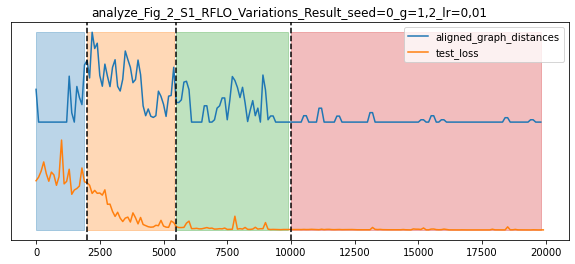

In [12]:
### --- Inspect individual training runs --- ###

i_analysis = 3
for i_analysis in [i_analysis]:
    key = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[key]['indices']
    fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                       key_restriction=['aligned_graph_distances', 'test_loss'],
                       stage_assignments=dict_of_stage_assignments[key])
    for t in dict_of_t_stage_transitions[key]:
        if t is not None:
            plt.axvline(indices[t], color='k', linestyle='--')
    plt.title(key)

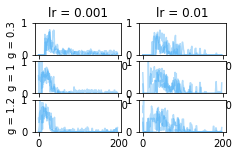

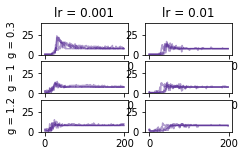

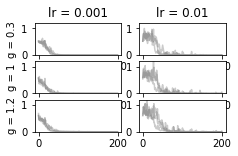

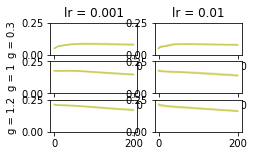

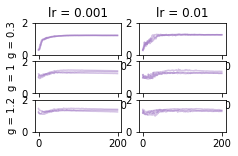

In [9]:
### --- GENERATE FIGURE S1 PLOT ALL RESULTS BY CURVE --- ###

sig = 'aligned_graph_distances'
colors_dict = {'aligned_graph_distances': '#3FA9F5',
               'n_nodes': '#3A0882',
               'test_loss': '#7F7F7F',
               'w_std': 'C8',
               'spectral_radius': 'C4'}
y_lim_dict = {'aligned_graph_distances': 1,
              'n_nodes': 40,
              'test_loss': 1.2,
              'w_std': 0.25,
              'spectral_radius': 2}
for sig in colors_dict.keys():
    fig = plot_array_of_signals(signal_dicts, root_name=root_name, signal_keys=[sig] ,alpha=0.4,
                                colors=[colors_dict[sig]],
                                return_fig=True, fig_length=2, swap_order=False, common_ylim=[0, y_lim_dict[sig]])
    #for i in range(6):
        #fig.axes[i].axis('off')
        #fig.axes[i].set_title('')
    figs_path = 'figs'
    fig_name = 'RFLO_Variations_raw_{}'.format(sig)
    #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

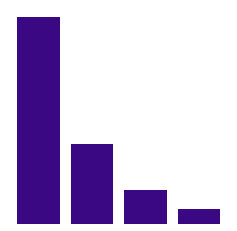

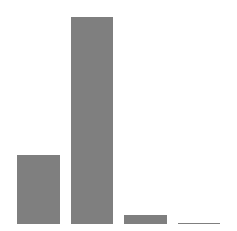

In [6]:
### --- FIGURE 2B CHANGES IN D_SYN AND L BY STAGE --- ###

## -- SYNAPTIC CHANGES -- ##

d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    d_syn = signals['rec_weight_distances']
    d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean() 
                        for i_stage in range(1, 5)]
    d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], d_syn_stage_means.mean(0), color='#3A0882')
plt.axis('off')
#fig.savefig('figs/fig2b_dsyn.pdf', dpi=300, format='pdf')

## -- LOSS CHANGES -- ##

d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    loss = signals['test_loss']
    d_loss = loss[1:] - loss[:-1]
    d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean() 
                         for i_stage in range(1, 5)]
    d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], -d_loss_stage_means.mean(0), color='#7F7F7F')
plt.axis('off')
#fig.savefig('figs/fig2b_dloss.pdf', dpi=300, format='pdf')

<ipython-input-7-13aa32cc1e3e>:28: RuntimeWarning: Mean of empty slice.
  d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean()
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-13aa32cc1e3e>:46: RuntimeWarning: Mean of empty slice.
  d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean()
<ipython-input-7-13aa32cc1e3e>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, 4))


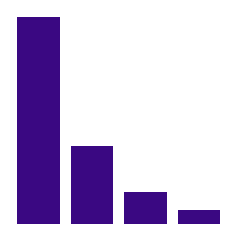

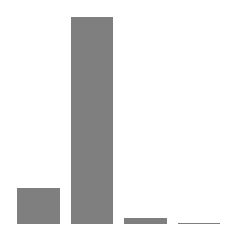

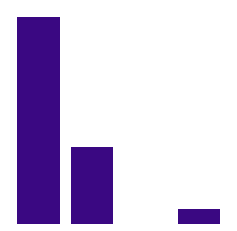

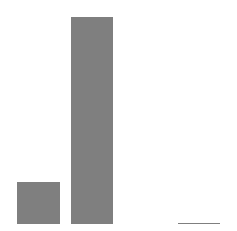

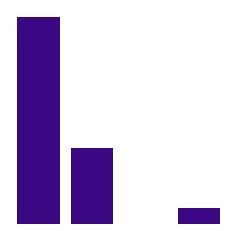

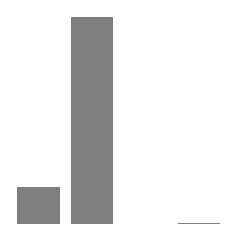

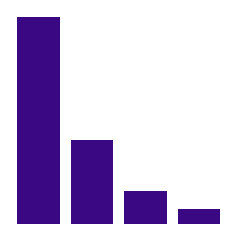

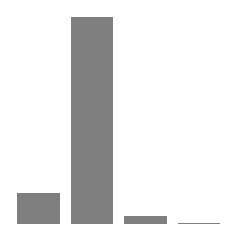

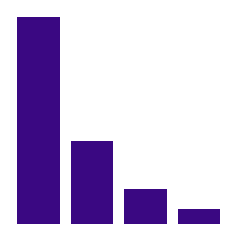

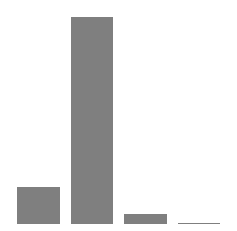

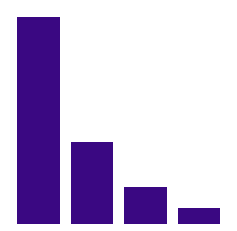

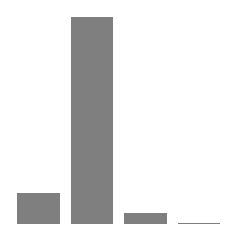

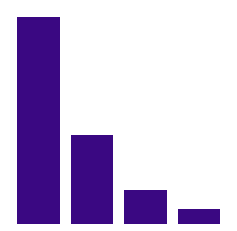

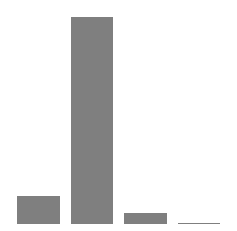

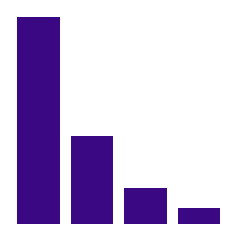

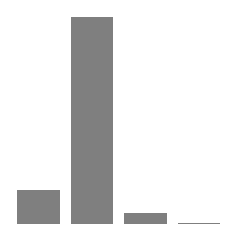

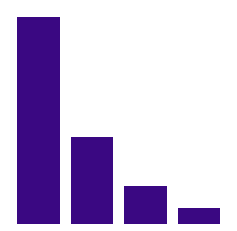

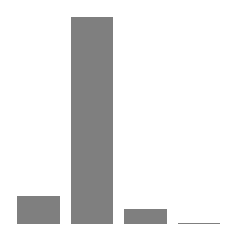

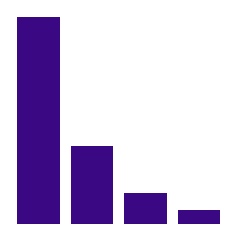

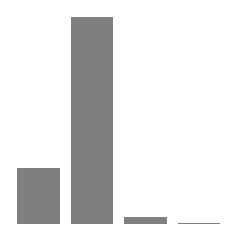

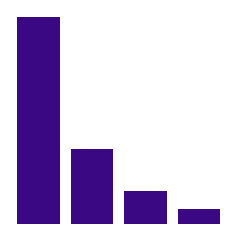

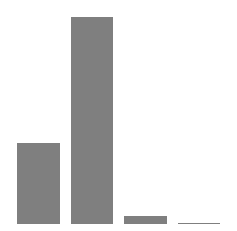

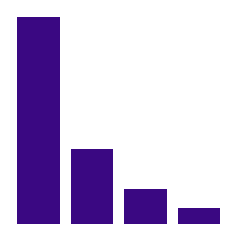

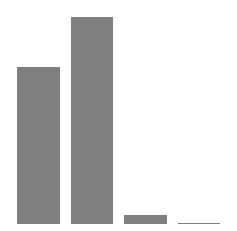

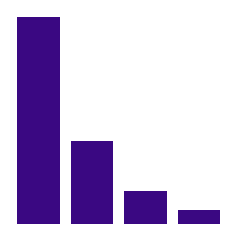

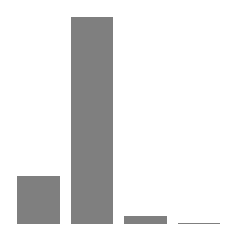

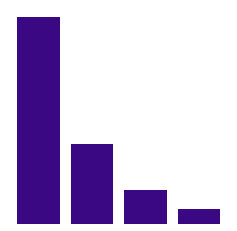

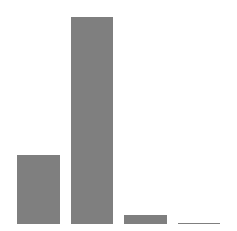

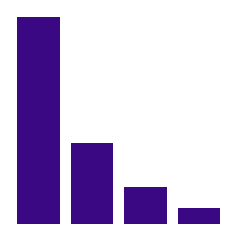

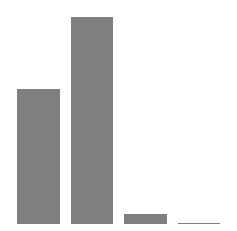

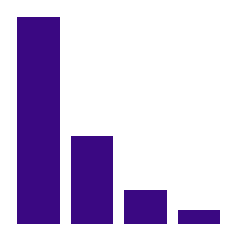

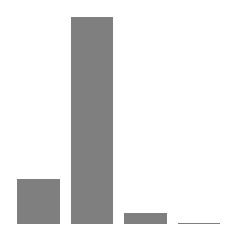

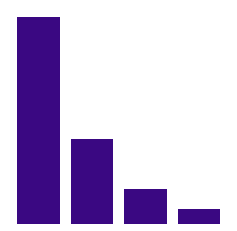

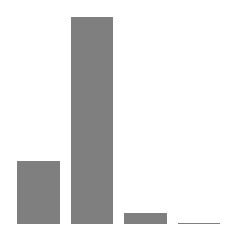

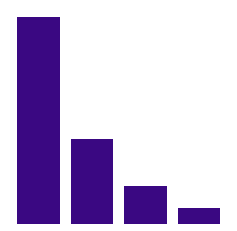

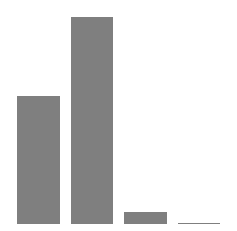

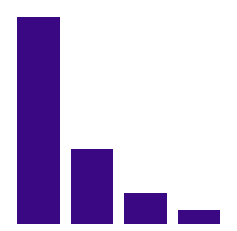

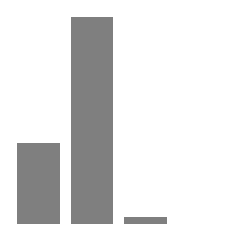

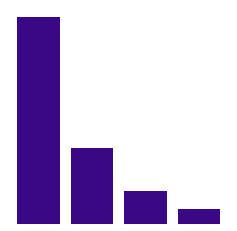

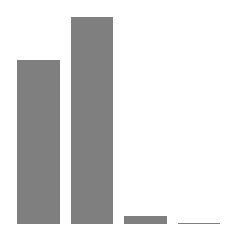

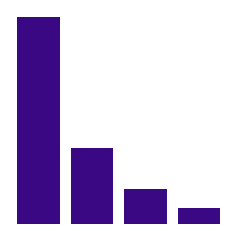

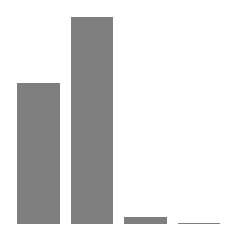

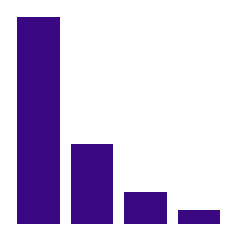

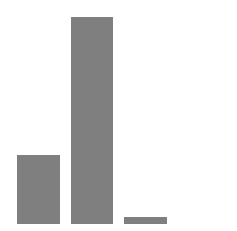

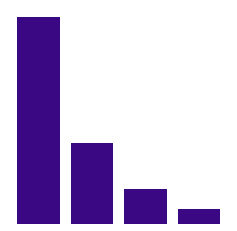

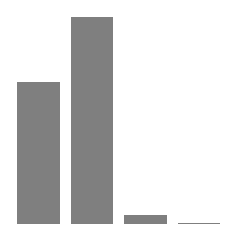

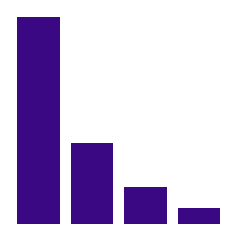

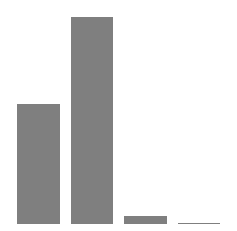

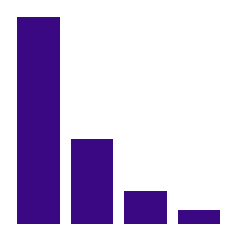

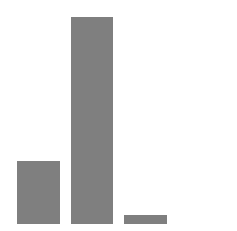

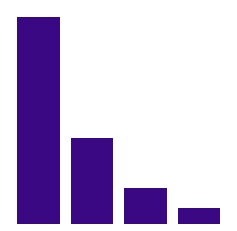

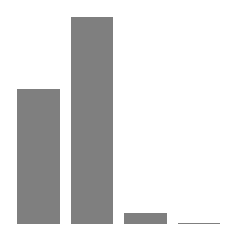

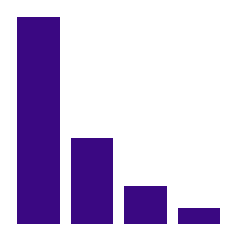

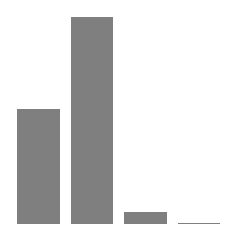

In [7]:
### --- FIGURE S2 ROBUST TO STAGE PARAMETERS --- ###

### --- Calculate stage transition points --- ###

for tw in [15, 20, 25]:
    for pc in [0.03, 0.05, 0.08]:
        for tc in [0.08, 0.1, 0.12]:
            dict_of_stage_assignments = {}
            dict_of_t_stage_transitions = {}
            for signal_key in signal_keys_ordered:
                signals = signal_dicts[signal_key]
                loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
                stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                                      performance_criterion=pc,
                                                                                      topological_criterion=tc,
                                                                                      loss_window=1,
                                                                                      topological_window=tw)
                dict_of_stage_assignments[signal_key] = stage_assignments
                dict_of_t_stage_transitions[signal_key] = t_stage_transitions
            
            ## -- SYNAPTIC CHANGES -- ##

            d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
            for i_key, key in enumerate(signal_keys_ordered):
                signals = signal_dicts[key]
                SA = dict_of_stage_assignments[key]
                d_syn = signals['rec_weight_distances']
                d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean() 
                                    for i_stage in range(1, 5)]
                d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
            fig = plt.figure(figsize=(4, 4))
            plt.bar([1,2,3,4], d_syn_stage_means.mean(0), color='#3A0882')
            plt.axis('off')
            figs_path = 'figs/FigS2_Robustness/'
            fig_name = 'figS2_dsyn_tw={}_pc={}_tc={}.pdf'.format(tw, pc, tc)
            fig.savefig(os.path.join(figs_path, fig_name), dpi=300, format='pdf')

            ## -- LOSS CHANGES -- ##

            d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
            for i_key, key in enumerate(signal_keys_ordered):
                signals = signal_dicts[key]
                SA = dict_of_stage_assignments[key]
                loss = signals['test_loss']
                d_loss = loss[1:] - loss[:-1]
                d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean() 
                                     for i_stage in range(1, 5)]
                d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
            fig = plt.figure(figsize=(4, 4))
            plt.bar([1,2,3,4], -d_loss_stage_means.mean(0), color='#7F7F7F')
            plt.axis('off')
            fig_name = 'figS2_dsyn_tw={}_pc={}_tc={}.pdf'.format(tw, pc, tc)
            fig.savefig(os.path.join(figs_path, fig_name), dpi=300, format='pdf')